In [137]:
import os
from sklearn.model_selection import train_test_split
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
import librosa
from tqdm.autonotebook import tqdm
import noisereduce as nr
import matplotlib.pyplot as plt
from sklearn import metrics
import scikitplot as skplt
from keras_radam import RAdam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [97]:
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, sr=16000,dtype=np.float16, res_type='kaiser_fast')
    yrn = nr.reduce_noise(audio_clip=wave, noise_clip=wave, verbose=False)
    yf, index = librosa.effects.trim(yrn,top_db=15)
    
    mfcc = librosa.feature.mfcc(y=yf, sr=16000, hop_length=1024, htk=True, n_mfcc=13)
    #mfcc_delta = librosa.feature.delta(mfcc,mode='nearest')
    #mfcc_delta2 = librosa.feature.delta(mfcc, order=2,mode='nearest')
    
    #mfcc = np.concatenate((mfcc, mfcc_delta,mfcc_delta2))
    #max_len = max_len *3
    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [98]:
def save_data_to_array(path,labels, max_len=11):
    dataset = getDataset(path,labels)
    print(np.sum([len(i) for i in dataset]))
    folder = path.replace("corpus","data2")
    for i,data in enumerate(dataset):
        # Init mfcc vectors
        mfcc_vectors = []
        for wavfile in data:
            mfcc = wav2mfcc(path + wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(folder + labels[i] + '.npy', mfcc_vectors)

In [99]:
def getDataset(path,labels):
    audioFiles = np.array(os.listdir(path))
    dataset = [
        audioFiles[np.char.find(audioFiles,name) == 4] for name in labels
    ]
    return dataset

In [100]:
def get_train_test(paths,labels, split_ratio=0.6, random_state=42):

    X_train, X_test, Y_train, Y_test = ([],[],[],[])
    for path in paths:
        ## PATH_DATA_WITHOUT_NOISE
        # Getting first arrays
        X = np.load(path+labels[0] + '.npy')
        y = np.zeros(X.shape[0])

        # Append all of the dataset into one single array, same goes for y
        for i, label in enumerate(labels[1:]):
            x = np.load(path + label + '.npy')
            X = np.vstack((X, x))
            y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

        assert X.shape[0] == len(y)

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)
        X_train.extend(x_train)
        X_test.extend(x_test)
        Y_train.extend(y_train)
        Y_test.extend(y_test)
    return (np.array(X_train), np.array(X_test), Y_train, Y_test)


In [101]:
labels = ["tournegauche","tournedroite","recule","plushaut","plusbas","gauche","faisunflip","etatdurgence","droite","decollage","avance","atterrissage","arretetoi"]

PATH_DATA_WITHOUT_NOISE = "corpus/drone_withoutnoise/"

save_data_to_array(PATH_DATA_WITHOUT_NOISE,labels)

PATH_DATA_WITH_NOISE = "corpus/drone_noise/"

save_data_to_array(PATH_DATA_WITH_NOISE,labels)

234
52


In [102]:
X_train, X_test, y_train, y_test = get_train_test(["data2/drone_withoutnoise/","data2/drone_noise/"],labels,0.8)

In [103]:
X_train.shape

(228, 13, 11)

In [104]:
X_test.shape

(58, 13, 11)

In [105]:
len(labels)

13

In [108]:
feature_dim_2 = 11
feature_dim_1 = 13
channel = 1
epochs = 50
batch_size = 256
verbose = 1
num_classes = len(labels)

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [109]:
X_train.shape

(228, 13, 11, 1)

In [166]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D(name='avg_pool'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [167]:
model_checkpoint = ModelCheckpoint('logs/checkpoint-inceptionresnetv2-v1-get-{epoch:02d}-{val_acc:.4f}.hdf5',monitor='val_acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-9, verbose=1)


In [168]:
model = get_model()
model.fit(X_train, y_train_hot, batch_size=210, epochs=1500, verbose=verbose, 
          validation_data=(X_test, y_test_hot))#,callbacks=[reduce_lr])

Train on 228 samples, validate on 58 samples
Epoch 1/1500
228/228 [==============================] - 0s 1ms/step - loss: 4.2207 - accuracy: 0.1140 - val_loss: 3.0147 - val_accuracy: 0.0172
Epoch 2/1500
228/228 [==============================] - 0s 169us/step - loss: 3.2436 - accuracy: 0.1009 - val_loss: 2.6815 - val_accuracy: 0.0517
Epoch 3/1500
228/228 [==============================] - 0s 154us/step - loss: 2.9444 - accuracy: 0.0746 - val_loss: 2.5670 - val_accuracy: 0.0690
Epoch 4/1500
228/228 [==============================] - 0s 159us/step - loss: 2.8122 - accuracy: 0.1140 - val_loss: 2.5501 - val_accuracy: 0.0862
Epoch 5/1500
228/228 [==============================] - 0s 159us/step - loss: 2.6411 - accuracy: 0.0526 - val_loss: 2.5481 - val_accuracy: 0.0690
Epoch 6/1500
228/228 [==============================] - 0s 166us/step - loss: 2.6794 - accuracy: 0.0746 - val_loss: 2.5502 - val_accuracy: 0.0862
Epoch 7/1500
228/228 [==============================] - 0s 167us/step - loss: 2.6

228/228 [==============================] - 0s 152us/step - loss: 2.5328 - accuracy: 0.0833 - val_loss: 2.5077 - val_accuracy: 0.1034
Epoch 57/1500
228/228 [==============================] - 0s 156us/step - loss: 2.5122 - accuracy: 0.1053 - val_loss: 2.5050 - val_accuracy: 0.1034
Epoch 58/1500
228/228 [==============================] - 0s 168us/step - loss: 2.5060 - accuracy: 0.1053 - val_loss: 2.5000 - val_accuracy: 0.1034
Epoch 59/1500
228/228 [==============================] - 0s 165us/step - loss: 2.4792 - accuracy: 0.1404 - val_loss: 2.4947 - val_accuracy: 0.1034
Epoch 60/1500
228/228 [==============================] - 0s 166us/step - loss: 2.4876 - accuracy: 0.1096 - val_loss: 2.4895 - val_accuracy: 0.0690
Epoch 61/1500
228/228 [==============================] - 0s 164us/step - loss: 2.4913 - accuracy: 0.1447 - val_loss: 2.4840 - val_accuracy: 0.0517
Epoch 62/1500
228/228 [==============================] - 0s 160us/step - loss: 2.4836 - accuracy: 0.1096 - val_loss: 2.4807 - val_ac

228/228 [==============================] - 0s 152us/step - loss: 1.8912 - accuracy: 0.3114 - val_loss: 1.7735 - val_accuracy: 0.3621
Epoch 112/1500
228/228 [==============================] - 0s 169us/step - loss: 1.9309 - accuracy: 0.3596 - val_loss: 1.7140 - val_accuracy: 0.2759
Epoch 113/1500
228/228 [==============================] - 0s 164us/step - loss: 1.8416 - accuracy: 0.3640 - val_loss: 1.7138 - val_accuracy: 0.2931
Epoch 114/1500
228/228 [==============================] - 0s 157us/step - loss: 1.8184 - accuracy: 0.3289 - val_loss: 1.6991 - val_accuracy: 0.2759
Epoch 115/1500
228/228 [==============================] - 0s 164us/step - loss: 1.8895 - accuracy: 0.2895 - val_loss: 1.6829 - val_accuracy: 0.2586
Epoch 116/1500
228/228 [==============================] - 0s 162us/step - loss: 1.7751 - accuracy: 0.3728 - val_loss: 1.6604 - val_accuracy: 0.2759
Epoch 117/1500
228/228 [==============================] - 0s 157us/step - loss: 1.7905 - accuracy: 0.3465 - val_loss: 1.6398 - 

228/228 [==============================] - 0s 160us/step - loss: 1.3584 - accuracy: 0.5702 - val_loss: 1.1973 - val_accuracy: 0.6379
Epoch 167/1500
228/228 [==============================] - 0s 146us/step - loss: 1.3541 - accuracy: 0.5614 - val_loss: 1.1595 - val_accuracy: 0.6724
Epoch 168/1500
228/228 [==============================] - 0s 155us/step - loss: 1.2505 - accuracy: 0.5570 - val_loss: 1.1883 - val_accuracy: 0.6552
Epoch 169/1500
228/228 [==============================] - 0s 161us/step - loss: 1.2996 - accuracy: 0.5570 - val_loss: 1.1982 - val_accuracy: 0.6552
Epoch 170/1500
228/228 [==============================] - 0s 155us/step - loss: 1.2877 - accuracy: 0.5570 - val_loss: 1.1880 - val_accuracy: 0.6379
Epoch 171/1500
228/228 [==============================] - 0s 151us/step - loss: 1.2943 - accuracy: 0.5307 - val_loss: 1.2063 - val_accuracy: 0.6379
Epoch 172/1500
228/228 [==============================] - 0s 167us/step - loss: 1.2416 - accuracy: 0.5658 - val_loss: 1.1744 - 

228/228 [==============================] - 0s 150us/step - loss: 0.8914 - accuracy: 0.7105 - val_loss: 0.8589 - val_accuracy: 0.6552
Epoch 222/1500
228/228 [==============================] - 0s 159us/step - loss: 0.8925 - accuracy: 0.7281 - val_loss: 0.8897 - val_accuracy: 0.6897
Epoch 223/1500
228/228 [==============================] - 0s 152us/step - loss: 0.9419 - accuracy: 0.6930 - val_loss: 0.8776 - val_accuracy: 0.7414
Epoch 224/1500
228/228 [==============================] - 0s 166us/step - loss: 0.8313 - accuracy: 0.7237 - val_loss: 0.8514 - val_accuracy: 0.7586
Epoch 225/1500
228/228 [==============================] - 0s 151us/step - loss: 0.8775 - accuracy: 0.6579 - val_loss: 0.8209 - val_accuracy: 0.7759
Epoch 226/1500
228/228 [==============================] - 0s 153us/step - loss: 0.8955 - accuracy: 0.6623 - val_loss: 0.8160 - val_accuracy: 0.7586
Epoch 227/1500
228/228 [==============================] - 0s 153us/step - loss: 0.9307 - accuracy: 0.6886 - val_loss: 0.8265 - 

228/228 [==============================] - 0s 158us/step - loss: 0.7231 - accuracy: 0.7588 - val_loss: 0.6991 - val_accuracy: 0.7759
Epoch 277/1500
228/228 [==============================] - 0s 145us/step - loss: 0.7279 - accuracy: 0.7544 - val_loss: 0.6768 - val_accuracy: 0.7931
Epoch 278/1500
228/228 [==============================] - 0s 164us/step - loss: 0.6295 - accuracy: 0.7851 - val_loss: 0.6773 - val_accuracy: 0.7759
Epoch 279/1500
228/228 [==============================] - 0s 152us/step - loss: 0.6539 - accuracy: 0.8114 - val_loss: 0.7001 - val_accuracy: 0.7759
Epoch 280/1500
228/228 [==============================] - 0s 154us/step - loss: 0.6568 - accuracy: 0.7500 - val_loss: 0.6900 - val_accuracy: 0.7931
Epoch 281/1500
228/228 [==============================] - 0s 163us/step - loss: 0.6433 - accuracy: 0.7632 - val_loss: 0.6611 - val_accuracy: 0.7759
Epoch 282/1500
228/228 [==============================] - 0s 159us/step - loss: 0.5861 - accuracy: 0.8202 - val_loss: 0.6416 - 

228/228 [==============================] - 0s 142us/step - loss: 0.5230 - accuracy: 0.8465 - val_loss: 0.6155 - val_accuracy: 0.7931
Epoch 332/1500
228/228 [==============================] - 0s 150us/step - loss: 0.5116 - accuracy: 0.8070 - val_loss: 0.6919 - val_accuracy: 0.7586
Epoch 333/1500
228/228 [==============================] - 0s 158us/step - loss: 0.4670 - accuracy: 0.8465 - val_loss: 0.7511 - val_accuracy: 0.7586
Epoch 334/1500
228/228 [==============================] - 0s 144us/step - loss: 0.5513 - accuracy: 0.8202 - val_loss: 0.7084 - val_accuracy: 0.7759
Epoch 335/1500
228/228 [==============================] - 0s 155us/step - loss: 0.6028 - accuracy: 0.7939 - val_loss: 0.6271 - val_accuracy: 0.8103
Epoch 336/1500
228/228 [==============================] - 0s 154us/step - loss: 0.4951 - accuracy: 0.8333 - val_loss: 0.5780 - val_accuracy: 0.7759
Epoch 337/1500
228/228 [==============================] - 0s 161us/step - loss: 0.5282 - accuracy: 0.8246 - val_loss: 0.5809 - 

228/228 [==============================] - 0s 147us/step - loss: 0.3258 - accuracy: 0.8904 - val_loss: 0.5777 - val_accuracy: 0.7931
Epoch 387/1500
228/228 [==============================] - 0s 159us/step - loss: 0.4351 - accuracy: 0.8640 - val_loss: 0.5944 - val_accuracy: 0.7931
Epoch 388/1500
228/228 [==============================] - 0s 156us/step - loss: 0.4064 - accuracy: 0.8684 - val_loss: 0.5986 - val_accuracy: 0.7931
Epoch 389/1500
228/228 [==============================] - 0s 158us/step - loss: 0.4614 - accuracy: 0.8509 - val_loss: 0.5699 - val_accuracy: 0.7931
Epoch 390/1500
228/228 [==============================] - 0s 161us/step - loss: 0.4136 - accuracy: 0.8553 - val_loss: 0.5466 - val_accuracy: 0.8103
Epoch 391/1500
228/228 [==============================] - 0s 156us/step - loss: 0.4066 - accuracy: 0.8947 - val_loss: 0.5680 - val_accuracy: 0.7931
Epoch 392/1500
228/228 [==============================] - 0s 148us/step - loss: 0.3724 - accuracy: 0.8596 - val_loss: 0.5827 - 

228/228 [==============================] - 0s 146us/step - loss: 0.2992 - accuracy: 0.8904 - val_loss: 0.5342 - val_accuracy: 0.8103
Epoch 442/1500
228/228 [==============================] - 0s 151us/step - loss: 0.3484 - accuracy: 0.8728 - val_loss: 0.5580 - val_accuracy: 0.8276
Epoch 443/1500
228/228 [==============================] - 0s 156us/step - loss: 0.3339 - accuracy: 0.8860 - val_loss: 0.5845 - val_accuracy: 0.8448
Epoch 444/1500
228/228 [==============================] - 0s 154us/step - loss: 0.3951 - accuracy: 0.8553 - val_loss: 0.5930 - val_accuracy: 0.8276
Epoch 445/1500
228/228 [==============================] - 0s 163us/step - loss: 0.3088 - accuracy: 0.9079 - val_loss: 0.6103 - val_accuracy: 0.7759
Epoch 446/1500
228/228 [==============================] - 0s 162us/step - loss: 0.3862 - accuracy: 0.8904 - val_loss: 0.6206 - val_accuracy: 0.7414
Epoch 447/1500
228/228 [==============================] - 0s 148us/step - loss: 0.4059 - accuracy: 0.8772 - val_loss: 0.6222 - 

228/228 [==============================] - 0s 146us/step - loss: 0.2858 - accuracy: 0.9123 - val_loss: 0.5097 - val_accuracy: 0.8103
Epoch 497/1500
228/228 [==============================] - 0s 150us/step - loss: 0.3089 - accuracy: 0.9035 - val_loss: 0.5215 - val_accuracy: 0.7931
Epoch 498/1500
228/228 [==============================] - 0s 158us/step - loss: 0.3067 - accuracy: 0.8991 - val_loss: 0.5498 - val_accuracy: 0.8276
Epoch 499/1500
228/228 [==============================] - 0s 149us/step - loss: 0.2824 - accuracy: 0.9035 - val_loss: 0.5494 - val_accuracy: 0.8103
Epoch 500/1500
228/228 [==============================] - 0s 150us/step - loss: 0.2609 - accuracy: 0.8860 - val_loss: 0.5415 - val_accuracy: 0.8276
Epoch 501/1500
228/228 [==============================] - 0s 160us/step - loss: 0.3069 - accuracy: 0.8860 - val_loss: 0.5245 - val_accuracy: 0.7931
Epoch 502/1500
228/228 [==============================] - 0s 153us/step - loss: 0.2541 - accuracy: 0.9211 - val_loss: 0.5211 - 

228/228 [==============================] - 0s 157us/step - loss: 0.3373 - accuracy: 0.8728 - val_loss: 0.5158 - val_accuracy: 0.8103
Epoch 552/1500
228/228 [==============================] - 0s 153us/step - loss: 0.2259 - accuracy: 0.9342 - val_loss: 0.4462 - val_accuracy: 0.8103
Epoch 553/1500
228/228 [==============================] - 0s 155us/step - loss: 0.3280 - accuracy: 0.8947 - val_loss: 0.4433 - val_accuracy: 0.8276
Epoch 554/1500
228/228 [==============================] - 0s 159us/step - loss: 0.2602 - accuracy: 0.9211 - val_loss: 0.4599 - val_accuracy: 0.8276
Epoch 555/1500
228/228 [==============================] - 0s 160us/step - loss: 0.2438 - accuracy: 0.9254 - val_loss: 0.4763 - val_accuracy: 0.8448
Epoch 556/1500
228/228 [==============================] - 0s 145us/step - loss: 0.2506 - accuracy: 0.9211 - val_loss: 0.4935 - val_accuracy: 0.8276
Epoch 557/1500
228/228 [==============================] - 0s 160us/step - loss: 0.2304 - accuracy: 0.9167 - val_loss: 0.5585 - 

228/228 [==============================] - 0s 148us/step - loss: 0.2387 - accuracy: 0.9298 - val_loss: 0.6004 - val_accuracy: 0.8276
Epoch 607/1500
228/228 [==============================] - 0s 150us/step - loss: 0.2320 - accuracy: 0.9254 - val_loss: 0.5535 - val_accuracy: 0.8276
Epoch 608/1500
228/228 [==============================] - 0s 158us/step - loss: 0.2091 - accuracy: 0.9342 - val_loss: 0.5398 - val_accuracy: 0.8448
Epoch 609/1500
228/228 [==============================] - 0s 162us/step - loss: 0.2238 - accuracy: 0.9342 - val_loss: 0.5130 - val_accuracy: 0.8793
Epoch 610/1500
228/228 [==============================] - 0s 149us/step - loss: 0.2544 - accuracy: 0.9079 - val_loss: 0.4820 - val_accuracy: 0.8621
Epoch 611/1500
228/228 [==============================] - 0s 155us/step - loss: 0.2013 - accuracy: 0.9342 - val_loss: 0.4769 - val_accuracy: 0.8621
Epoch 612/1500
228/228 [==============================] - 0s 160us/step - loss: 0.2083 - accuracy: 0.9386 - val_loss: 0.4813 - 

228/228 [==============================] - 0s 152us/step - loss: 0.2231 - accuracy: 0.9211 - val_loss: 0.4980 - val_accuracy: 0.8103
Epoch 662/1500
228/228 [==============================] - 0s 150us/step - loss: 0.1892 - accuracy: 0.9605 - val_loss: 0.5028 - val_accuracy: 0.8276
Epoch 663/1500
228/228 [==============================] - 0s 154us/step - loss: 0.1943 - accuracy: 0.9254 - val_loss: 0.5249 - val_accuracy: 0.8276
Epoch 664/1500
228/228 [==============================] - 0s 155us/step - loss: 0.1497 - accuracy: 0.9518 - val_loss: 0.5476 - val_accuracy: 0.8103
Epoch 665/1500
228/228 [==============================] - 0s 160us/step - loss: 0.1778 - accuracy: 0.9254 - val_loss: 0.5388 - val_accuracy: 0.8103
Epoch 666/1500
228/228 [==============================] - 0s 156us/step - loss: 0.1744 - accuracy: 0.9430 - val_loss: 0.5057 - val_accuracy: 0.8103
Epoch 667/1500
228/228 [==============================] - 0s 156us/step - loss: 0.1416 - accuracy: 0.9474 - val_loss: 0.4958 - 

228/228 [==============================] - 0s 149us/step - loss: 0.1845 - accuracy: 0.9342 - val_loss: 0.4686 - val_accuracy: 0.8103
Epoch 717/1500
228/228 [==============================] - 0s 148us/step - loss: 0.2027 - accuracy: 0.9342 - val_loss: 0.4556 - val_accuracy: 0.8276
Epoch 718/1500
228/228 [==============================] - 0s 158us/step - loss: 0.1845 - accuracy: 0.9430 - val_loss: 0.4617 - val_accuracy: 0.8448
Epoch 719/1500
228/228 [==============================] - 0s 156us/step - loss: 0.1874 - accuracy: 0.9561 - val_loss: 0.4753 - val_accuracy: 0.8276
Epoch 720/1500
228/228 [==============================] - 0s 163us/step - loss: 0.1647 - accuracy: 0.9781 - val_loss: 0.4919 - val_accuracy: 0.8276
Epoch 721/1500
228/228 [==============================] - 0s 162us/step - loss: 0.1638 - accuracy: 0.9561 - val_loss: 0.5213 - val_accuracy: 0.8103
Epoch 722/1500
228/228 [==============================] - 0s 156us/step - loss: 0.1728 - accuracy: 0.9386 - val_loss: 0.5443 - 

228/228 [==============================] - 0s 139us/step - loss: 0.2025 - accuracy: 0.9254 - val_loss: 0.5192 - val_accuracy: 0.7931
Epoch 772/1500
228/228 [==============================] - 0s 160us/step - loss: 0.1199 - accuracy: 0.9649 - val_loss: 0.4795 - val_accuracy: 0.7931
Epoch 773/1500
228/228 [==============================] - 0s 158us/step - loss: 0.1264 - accuracy: 0.9561 - val_loss: 0.4623 - val_accuracy: 0.8276
Epoch 774/1500
228/228 [==============================] - 0s 157us/step - loss: 0.1628 - accuracy: 0.9474 - val_loss: 0.4769 - val_accuracy: 0.8103
Epoch 775/1500
228/228 [==============================] - 0s 162us/step - loss: 0.1162 - accuracy: 0.9693 - val_loss: 0.4810 - val_accuracy: 0.8276
Epoch 776/1500
228/228 [==============================] - 0s 147us/step - loss: 0.1606 - accuracy: 0.9474 - val_loss: 0.4396 - val_accuracy: 0.8276
Epoch 777/1500
228/228 [==============================] - 0s 155us/step - loss: 0.1613 - accuracy: 0.9474 - val_loss: 0.4254 - 

228/228 [==============================] - 0s 164us/step - loss: 0.1170 - accuracy: 0.9561 - val_loss: 0.4879 - val_accuracy: 0.8448
Epoch 827/1500
228/228 [==============================] - 0s 156us/step - loss: 0.0760 - accuracy: 0.9737 - val_loss: 0.5190 - val_accuracy: 0.8448
Epoch 828/1500
228/228 [==============================] - 0s 150us/step - loss: 0.1397 - accuracy: 0.9518 - val_loss: 0.5429 - val_accuracy: 0.8276
Epoch 829/1500
228/228 [==============================] - 0s 153us/step - loss: 0.1731 - accuracy: 0.9386 - val_loss: 0.5491 - val_accuracy: 0.8276
Epoch 830/1500
228/228 [==============================] - 0s 148us/step - loss: 0.1538 - accuracy: 0.9561 - val_loss: 0.5196 - val_accuracy: 0.8448
Epoch 831/1500
228/228 [==============================] - 0s 158us/step - loss: 0.1050 - accuracy: 0.9737 - val_loss: 0.4816 - val_accuracy: 0.8448
Epoch 832/1500
228/228 [==============================] - 0s 153us/step - loss: 0.1759 - accuracy: 0.9386 - val_loss: 0.4807 - 

228/228 [==============================] - 0s 150us/step - loss: 0.1452 - accuracy: 0.9474 - val_loss: 0.4399 - val_accuracy: 0.8276
Epoch 882/1500
228/228 [==============================] - 0s 154us/step - loss: 0.1130 - accuracy: 0.9649 - val_loss: 0.4248 - val_accuracy: 0.8448
Epoch 883/1500
228/228 [==============================] - 0s 160us/step - loss: 0.1152 - accuracy: 0.9781 - val_loss: 0.4166 - val_accuracy: 0.8448
Epoch 884/1500
228/228 [==============================] - 0s 163us/step - loss: 0.1812 - accuracy: 0.9430 - val_loss: 0.4162 - val_accuracy: 0.8448
Epoch 885/1500
228/228 [==============================] - 0s 155us/step - loss: 0.1910 - accuracy: 0.9386 - val_loss: 0.4309 - val_accuracy: 0.8448
Epoch 886/1500
228/228 [==============================] - 0s 161us/step - loss: 0.1725 - accuracy: 0.9342 - val_loss: 0.4525 - val_accuracy: 0.8103
Epoch 887/1500
228/228 [==============================] - 0s 152us/step - loss: 0.1001 - accuracy: 0.9781 - val_loss: 0.4775 - 

228/228 [==============================] - 0s 148us/step - loss: 0.1207 - accuracy: 0.9605 - val_loss: 0.5330 - val_accuracy: 0.7759
Epoch 937/1500
228/228 [==============================] - 0s 165us/step - loss: 0.1498 - accuracy: 0.9430 - val_loss: 0.4684 - val_accuracy: 0.8276
Epoch 938/1500
228/228 [==============================] - 0s 171us/step - loss: 0.1181 - accuracy: 0.9561 - val_loss: 0.4216 - val_accuracy: 0.8276
Epoch 939/1500
228/228 [==============================] - 0s 167us/step - loss: 0.0972 - accuracy: 0.9693 - val_loss: 0.4318 - val_accuracy: 0.8448
Epoch 940/1500
228/228 [==============================] - 0s 165us/step - loss: 0.1610 - accuracy: 0.9342 - val_loss: 0.4415 - val_accuracy: 0.8448
Epoch 941/1500
228/228 [==============================] - 0s 158us/step - loss: 0.1722 - accuracy: 0.9518 - val_loss: 0.4549 - val_accuracy: 0.8276
Epoch 942/1500
228/228 [==============================] - 0s 168us/step - loss: 0.1245 - accuracy: 0.9693 - val_loss: 0.4698 - 

228/228 [==============================] - 0s 159us/step - loss: 0.1070 - accuracy: 0.9649 - val_loss: 0.5255 - val_accuracy: 0.8276
Epoch 992/1500
228/228 [==============================] - 0s 155us/step - loss: 0.0675 - accuracy: 0.9693 - val_loss: 0.5209 - val_accuracy: 0.8276
Epoch 993/1500
228/228 [==============================] - 0s 146us/step - loss: 0.0969 - accuracy: 0.9737 - val_loss: 0.5257 - val_accuracy: 0.8448
Epoch 994/1500
228/228 [==============================] - 0s 153us/step - loss: 0.0897 - accuracy: 0.9649 - val_loss: 0.5357 - val_accuracy: 0.8448
Epoch 995/1500
228/228 [==============================] - 0s 152us/step - loss: 0.0995 - accuracy: 0.9693 - val_loss: 0.5367 - val_accuracy: 0.8276
Epoch 996/1500
228/228 [==============================] - 0s 154us/step - loss: 0.1057 - accuracy: 0.9649 - val_loss: 0.5315 - val_accuracy: 0.8448
Epoch 997/1500
228/228 [==============================] - 0s 157us/step - loss: 0.1027 - accuracy: 0.9693 - val_loss: 0.5166 - 

228/228 [==============================] - 0s 136us/step - loss: 0.1276 - accuracy: 0.9561 - val_loss: 0.5759 - val_accuracy: 0.8276
Epoch 1047/1500
228/228 [==============================] - 0s 153us/step - loss: 0.1021 - accuracy: 0.9605 - val_loss: 0.6118 - val_accuracy: 0.8276
Epoch 1048/1500
228/228 [==============================] - 0s 156us/step - loss: 0.0875 - accuracy: 0.9737 - val_loss: 0.6327 - val_accuracy: 0.8103
Epoch 1049/1500
228/228 [==============================] - 0s 156us/step - loss: 0.0752 - accuracy: 0.9693 - val_loss: 0.6427 - val_accuracy: 0.7931
Epoch 1050/1500
228/228 [==============================] - 0s 159us/step - loss: 0.0787 - accuracy: 0.9781 - val_loss: 0.6261 - val_accuracy: 0.7931
Epoch 1051/1500
228/228 [==============================] - 0s 160us/step - loss: 0.1116 - accuracy: 0.9649 - val_loss: 0.5882 - val_accuracy: 0.7931
Epoch 1052/1500
228/228 [==============================] - 0s 159us/step - loss: 0.0820 - accuracy: 0.9737 - val_loss: 0.5

228/228 [==============================] - 0s 149us/step - loss: 0.1390 - accuracy: 0.9561 - val_loss: 0.6126 - val_accuracy: 0.8448
Epoch 1102/1500
228/228 [==============================] - 0s 143us/step - loss: 0.1473 - accuracy: 0.9649 - val_loss: 0.6075 - val_accuracy: 0.8448
Epoch 1103/1500
228/228 [==============================] - 0s 143us/step - loss: 0.1331 - accuracy: 0.9474 - val_loss: 0.5899 - val_accuracy: 0.8621
Epoch 1104/1500
228/228 [==============================] - 0s 146us/step - loss: 0.1523 - accuracy: 0.9474 - val_loss: 0.6105 - val_accuracy: 0.8448
Epoch 1105/1500
228/228 [==============================] - 0s 158us/step - loss: 0.1040 - accuracy: 0.9781 - val_loss: 0.6114 - val_accuracy: 0.8448
Epoch 1106/1500
228/228 [==============================] - 0s 155us/step - loss: 0.0638 - accuracy: 0.9825 - val_loss: 0.6037 - val_accuracy: 0.8448
Epoch 1107/1500
228/228 [==============================] - 0s 149us/step - loss: 0.1133 - accuracy: 0.9605 - val_loss: 0.5

228/228 [==============================] - 0s 151us/step - loss: 0.0789 - accuracy: 0.9737 - val_loss: 0.5518 - val_accuracy: 0.8448
Epoch 1157/1500
228/228 [==============================] - 0s 150us/step - loss: 0.1022 - accuracy: 0.9737 - val_loss: 0.5635 - val_accuracy: 0.8621
Epoch 1158/1500
228/228 [==============================] - 0s 151us/step - loss: 0.0724 - accuracy: 0.9781 - val_loss: 0.5724 - val_accuracy: 0.8448
Epoch 1159/1500
228/228 [==============================] - 0s 150us/step - loss: 0.1332 - accuracy: 0.9518 - val_loss: 0.5864 - val_accuracy: 0.8448
Epoch 1160/1500
228/228 [==============================] - 0s 145us/step - loss: 0.0736 - accuracy: 0.9693 - val_loss: 0.6133 - val_accuracy: 0.8448
Epoch 1161/1500
228/228 [==============================] - 0s 153us/step - loss: 0.0884 - accuracy: 0.9693 - val_loss: 0.6337 - val_accuracy: 0.8276
Epoch 1162/1500
228/228 [==============================] - 0s 161us/step - loss: 0.1250 - accuracy: 0.9605 - val_loss: 0.6

228/228 [==============================] - 0s 143us/step - loss: 0.0914 - accuracy: 0.9693 - val_loss: 0.6092 - val_accuracy: 0.7931
Epoch 1212/1500
228/228 [==============================] - 0s 146us/step - loss: 0.0896 - accuracy: 0.9737 - val_loss: 0.6091 - val_accuracy: 0.7931
Epoch 1213/1500
228/228 [==============================] - 0s 151us/step - loss: 0.1136 - accuracy: 0.9649 - val_loss: 0.6046 - val_accuracy: 0.7931
Epoch 1214/1500
228/228 [==============================] - 0s 159us/step - loss: 0.0815 - accuracy: 0.9781 - val_loss: 0.5964 - val_accuracy: 0.8103
Epoch 1215/1500
228/228 [==============================] - 0s 157us/step - loss: 0.0691 - accuracy: 0.9825 - val_loss: 0.5881 - val_accuracy: 0.8103
Epoch 1216/1500
228/228 [==============================] - 0s 150us/step - loss: 0.0754 - accuracy: 0.9737 - val_loss: 0.5675 - val_accuracy: 0.8103
Epoch 1217/1500
228/228 [==============================] - 0s 150us/step - loss: 0.0613 - accuracy: 0.9825 - val_loss: 0.5

228/228 [==============================] - 0s 162us/step - loss: 0.0846 - accuracy: 0.9693 - val_loss: 0.5027 - val_accuracy: 0.7931
Epoch 1267/1500
228/228 [==============================] - 0s 152us/step - loss: 0.0632 - accuracy: 0.9737 - val_loss: 0.5049 - val_accuracy: 0.8103
Epoch 1268/1500
228/228 [==============================] - 0s 155us/step - loss: 0.0630 - accuracy: 0.9912 - val_loss: 0.5143 - val_accuracy: 0.8448
Epoch 1269/1500
228/228 [==============================] - 0s 164us/step - loss: 0.0512 - accuracy: 0.9912 - val_loss: 0.5274 - val_accuracy: 0.8448
Epoch 1270/1500
228/228 [==============================] - 0s 147us/step - loss: 0.0837 - accuracy: 0.9693 - val_loss: 0.5405 - val_accuracy: 0.8448
Epoch 1271/1500
228/228 [==============================] - 0s 149us/step - loss: 0.0789 - accuracy: 0.9737 - val_loss: 0.5623 - val_accuracy: 0.7931
Epoch 1272/1500
228/228 [==============================] - 0s 149us/step - loss: 0.0681 - accuracy: 0.9781 - val_loss: 0.5

228/228 [==============================] - 0s 141us/step - loss: 0.1001 - accuracy: 0.9737 - val_loss: 0.5485 - val_accuracy: 0.8103
Epoch 1322/1500
228/228 [==============================] - 0s 143us/step - loss: 0.0778 - accuracy: 0.9781 - val_loss: 0.5418 - val_accuracy: 0.8103
Epoch 1323/1500
228/228 [==============================] - 0s 143us/step - loss: 0.0897 - accuracy: 0.9737 - val_loss: 0.5102 - val_accuracy: 0.8103
Epoch 1324/1500
228/228 [==============================] - 0s 143us/step - loss: 0.0799 - accuracy: 0.9781 - val_loss: 0.4862 - val_accuracy: 0.8448
Epoch 1325/1500
228/228 [==============================] - 0s 148us/step - loss: 0.0556 - accuracy: 0.9868 - val_loss: 0.5047 - val_accuracy: 0.8276
Epoch 1326/1500
228/228 [==============================] - 0s 143us/step - loss: 0.0770 - accuracy: 0.9693 - val_loss: 0.5280 - val_accuracy: 0.8276
Epoch 1327/1500
228/228 [==============================] - 0s 150us/step - loss: 0.0695 - accuracy: 0.9825 - val_loss: 0.5

228/228 [==============================] - 0s 144us/step - loss: 0.0748 - accuracy: 0.9693 - val_loss: 0.5519 - val_accuracy: 0.8621
Epoch 1377/1500
228/228 [==============================] - 0s 160us/step - loss: 0.0568 - accuracy: 0.9781 - val_loss: 0.5474 - val_accuracy: 0.8448
Epoch 1378/1500
228/228 [==============================] - 0s 158us/step - loss: 0.0725 - accuracy: 0.9781 - val_loss: 0.5574 - val_accuracy: 0.8448
Epoch 1379/1500
228/228 [==============================] - 0s 156us/step - loss: 0.0640 - accuracy: 0.9693 - val_loss: 0.5818 - val_accuracy: 0.8448
Epoch 1380/1500
228/228 [==============================] - 0s 158us/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.6279 - val_accuracy: 0.8448
Epoch 1381/1500
228/228 [==============================] - 0s 151us/step - loss: 0.0982 - accuracy: 0.9605 - val_loss: 0.6232 - val_accuracy: 0.8448
Epoch 1382/1500
228/228 [==============================] - 0s 144us/step - loss: 0.0690 - accuracy: 0.9868 - val_loss: 0.5

228/228 [==============================] - 0s 143us/step - loss: 0.0358 - accuracy: 0.9868 - val_loss: 0.5210 - val_accuracy: 0.8448
Epoch 1432/1500
228/228 [==============================] - 0s 155us/step - loss: 0.0655 - accuracy: 0.9737 - val_loss: 0.5089 - val_accuracy: 0.8448
Epoch 1433/1500
228/228 [==============================] - 0s 166us/step - loss: 0.0499 - accuracy: 0.9868 - val_loss: 0.4909 - val_accuracy: 0.8793
Epoch 1434/1500
228/228 [==============================] - 0s 154us/step - loss: 0.0400 - accuracy: 0.9912 - val_loss: 0.4727 - val_accuracy: 0.8793
Epoch 1435/1500
228/228 [==============================] - 0s 155us/step - loss: 0.0988 - accuracy: 0.9605 - val_loss: 0.4922 - val_accuracy: 0.8793
Epoch 1436/1500
228/228 [==============================] - 0s 148us/step - loss: 0.0719 - accuracy: 0.9693 - val_loss: 0.5399 - val_accuracy: 0.8103
Epoch 1437/1500
228/228 [==============================] - 0s 157us/step - loss: 0.0628 - accuracy: 0.9868 - val_loss: 0.5

228/228 [==============================] - 0s 158us/step - loss: 0.0812 - accuracy: 0.9781 - val_loss: 0.6498 - val_accuracy: 0.8103
Epoch 1487/1500
228/228 [==============================] - 0s 149us/step - loss: 0.1012 - accuracy: 0.9561 - val_loss: 0.6230 - val_accuracy: 0.8103
Epoch 1488/1500
228/228 [==============================] - 0s 160us/step - loss: 0.0792 - accuracy: 0.9693 - val_loss: 0.5620 - val_accuracy: 0.8276
Epoch 1489/1500
228/228 [==============================] - 0s 159us/step - loss: 0.0549 - accuracy: 0.9781 - val_loss: 0.5333 - val_accuracy: 0.8448
Epoch 1490/1500
228/228 [==============================] - 0s 149us/step - loss: 0.0720 - accuracy: 0.9781 - val_loss: 0.4972 - val_accuracy: 0.8621
Epoch 1491/1500
228/228 [==============================] - 0s 150us/step - loss: 0.0465 - accuracy: 0.9956 - val_loss: 0.4576 - val_accuracy: 0.8793
Epoch 1492/1500
228/228 [==============================] - 0s 155us/step - loss: 0.0771 - accuracy: 0.9737 - val_loss: 0.4

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


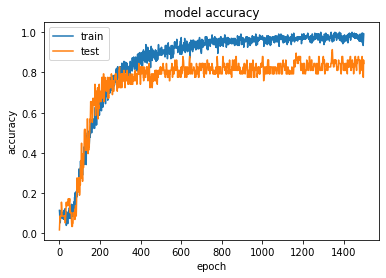

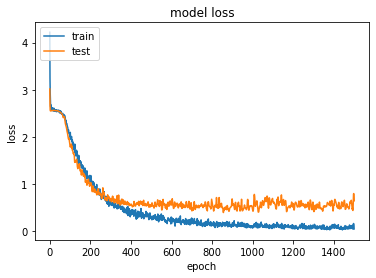

In [169]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [170]:
np.max(model.history.history['val_accuracy'])

0.9137930870056152

### Adam, softmax, delta, delta2

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


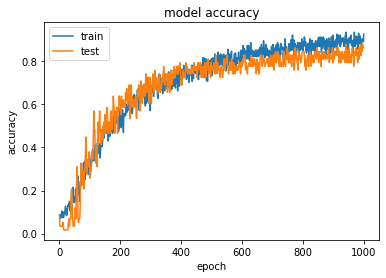

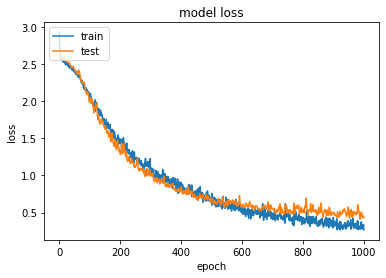

In [95]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
np.max(model.history.history['val_accuracy'])

0.8793103694915771

In [52]:
x = wav2mfcc("M11_etatdurgence.wav")

In [53]:
np.expand_dims(np.expand_dims(x, axis=2),axis=0).shape

(1, 20, 11, 1)

In [54]:
labels

['tournegauche',
 'tournedroite',
 'recule',
 'plushaut',
 'plusbas',
 'gauche',
 'faisunflip',
 'etatdurgence',
 'droite',
 'decollage',
 'avance',
 'atterrissage',
 'arretetoi']

In [55]:
b = model.predict(np.expand_dims(np.expand_dims(wav2mfcc("M11_etatdurgence.wav"),axis=2),axis=0))

In [56]:
labels[np.argmax(b)]

'etatdurgence'

In [57]:
model.evaluate(X_test,y_test_hot)

58/58 [==============================] - 0s 81us/step


[0.3957885401002292, 0.8448275923728943]

In [59]:
y_pred=model.predict_classes(X_test)

In [44]:
X_test.shape

(30, 20, 11, 1)

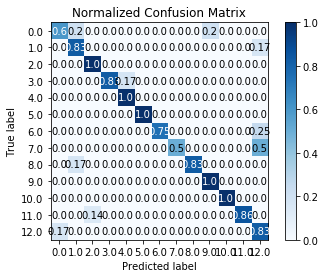

In [61]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

In [66]:
print(metrics.classification_report(y_test, y_pred,digits=2))

              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67         5
         1.0       0.71      0.83      0.77         6
         2.0       0.50      1.00      0.67         1
         3.0       1.00      0.83      0.91         6
         4.0       0.83      1.00      0.91         5
         5.0       1.00      1.00      1.00         2
         6.0       1.00      0.75      0.86         4
         7.0       1.00      0.50      0.67         2
         8.0       1.00      0.83      0.91         6
         9.0       0.75      1.00      0.86         3
        10.0       1.00      1.00      1.00         5
        11.0       1.00      0.86      0.92         7
        12.0       0.62      0.83      0.71         6

    accuracy                           0.84        58
   macro avg       0.86      0.85      0.83        58
weighted avg       0.87      0.84      0.85        58

